<a href="https://colab.research.google.com/github/Samy-Annasri/ReverseForecasAttack/blob/main/ReverseForecasAttack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT

In [46]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [47]:
import sys
import os

def in_colab():
    return 'google.colab' in sys.modules

if in_colab():
    repo_name = "ReverseForecasAttack"
    ipynb_name = "genetic_algorithm_adv.ipynb"
    cwd = os.getcwd()
    basename = os.path.basename(cwd)

    if basename != repo_name:
        if not os.path.exists(repo_name):
            !git clone https://github.com/Samy-Annasri/ReverseForecasAttack.git
        %cd {repo_name}
        %rm {ipynb_name}



In [48]:
import sys
'''
supre code for any module just for test so in #
if 'prepare_stock_dataset' in globals():
    del globals()['prepare_stock_dataset']

module_name = 'utils.setup_google_stock_dataset'
if module_name in sys.modules:
    del sys.modules[module_name]
'''


"\nsupre code for any module just for test so in #\nif 'prepare_stock_dataset' in globals():\n    del globals()['prepare_stock_dataset']\n\nmodule_name = 'utils.setup_google_stock_dataset'\nif module_name in sys.modules:\n    del sys.modules[module_name]\n"

## STEP 1: PREP DATA

In [49]:
google_data = pd.read_csv("data/HistoricalData_1747091015337.csv")
google_data['Date'] = pd.to_datetime(google_data['Date'])
google_data = google_data.sort_values(by='Date')

In [50]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
sequence_length = 30
result = prepare_stock_dataset(google_data)

train_loader = result['train_loader']
test_loader = result['test_loader']
train_size = result['train_size']
min_max = result['min_max']
dates = result['dates']
price_min, price_max = min_max['Close/Last']


## STEP 2: TRAIN NORMAL LSTM

In [51]:
from utils.train_model import train_model
from models.lstm import SimpleLSTM
model_google = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_google.parameters(), lr=0.001)
num_epochs = 30
train_model(model_google, loss_fn, optimizer, num_epochs, train_loader)

Epoch [1/30], Train Loss: 0.0324
Epoch [2/30], Train Loss: 0.0066
Epoch [3/30], Train Loss: 0.0021
Epoch [4/30], Train Loss: 0.0012
Epoch [5/30], Train Loss: 0.0011
Epoch [6/30], Train Loss: 0.0009
Epoch [7/30], Train Loss: 0.0009
Epoch [8/30], Train Loss: 0.0009
Epoch [9/30], Train Loss: 0.0009
Epoch [10/30], Train Loss: 0.0009
Epoch [11/30], Train Loss: 0.0009
Epoch [12/30], Train Loss: 0.0009
Epoch [13/30], Train Loss: 0.0008
Epoch [14/30], Train Loss: 0.0008
Epoch [15/30], Train Loss: 0.0008
Epoch [16/30], Train Loss: 0.0009
Epoch [17/30], Train Loss: 0.0008
Epoch [18/30], Train Loss: 0.0008
Epoch [19/30], Train Loss: 0.0008
Epoch [20/30], Train Loss: 0.0007
Epoch [21/30], Train Loss: 0.0007
Epoch [22/30], Train Loss: 0.0008
Epoch [23/30], Train Loss: 0.0007
Epoch [24/30], Train Loss: 0.0007
Epoch [25/30], Train Loss: 0.0007
Epoch [26/30], Train Loss: 0.0007
Epoch [27/30], Train Loss: 0.0007
Epoch [28/30], Train Loss: 0.0007
Epoch [29/30], Train Loss: 0.0007
Epoch [30/30], Train Lo

In [52]:
from utils.google_eval import evaluate_model_google
results = evaluate_model_google(model_google, test_loader, dates, train_size)

real_values = results['real_values']
predicted_values = results['predicted_values']
test_dates = results['test_dates']

In [53]:
# Computes scalar similarity (cosine similarity) between true and predicted values.
# Higher values indicate that adversarial predictions remain directionally aligned
# with the true values, suggesting stealthy and rational attacks!
def scalar_similarity(y_true, y_pred):
    numerator = np.dot(y_true, y_pred)
    denominator = np.linalg.norm(y_true) * np.linalg.norm(y_pred)
    if denominator == 0:
        return 0.0
    return numerator / denominator

In [54]:
# Creation of the tab result for plotting adversial attack result
models = ['LSTM']
metrics = ['MAE', "RMSE", 'SIM']

row_index = pd.MultiIndex.from_product([models, metrics], names=['Model', 'Metric'])

attacks = ['NA','REV']
epsilons = {
    'NA': [0],
    'REV':[0,0.01,0.1,0.2],
}

col_tuples = []
for atk, eps_list in epsilons.items():
    for eps in eps_list:
        col_tuples.append((atk, f"{eps:.2f}"))

col_index = pd.MultiIndex.from_tuples(col_tuples, names=['Attack', 'ε'])

res_tab = pd.DataFrame(index=row_index, columns=col_index, dtype=float)

print(res_tab)

Attack         NA  REV               
ε            0.00 0.00 0.01 0.10 0.20
Model Metric                         
LSTM  MAE     NaN  NaN  NaN  NaN  NaN
      RMSE    NaN  NaN  NaN  NaN  NaN
      SIM     NaN  NaN  NaN  NaN  NaN


LSTM | NA – Epsilon 0.00 – MAE: 4.1795 | SIM: 0.9996


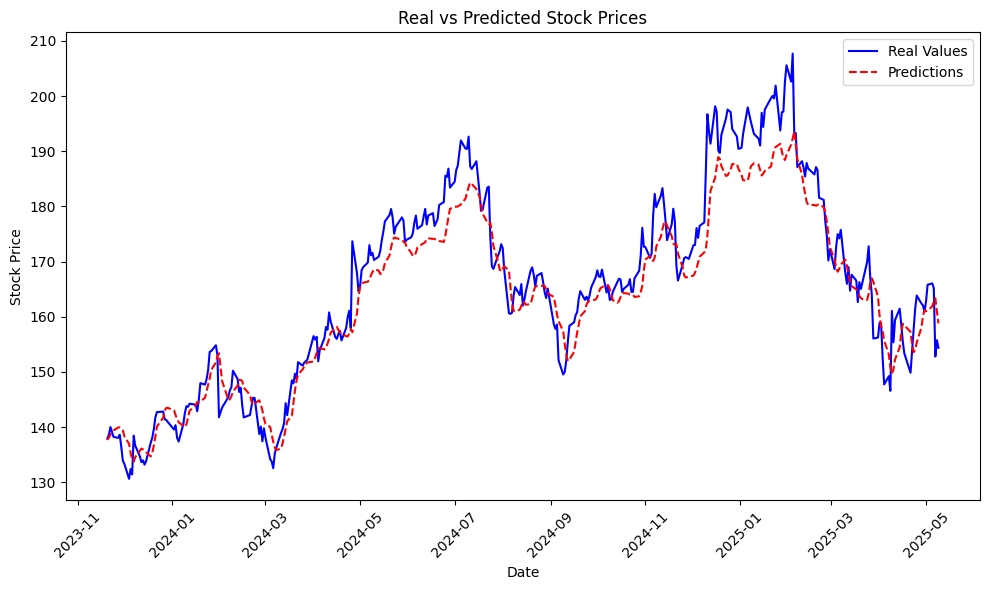

In [55]:
from utils.log_and_plot import log_and_plot_predictions
# Denormalize
true_values_denorm = real_values * (price_max - price_min) + price_min
predictions_denorm = predicted_values * (price_max - price_min) + price_min

log_and_plot_predictions(
    true_values=true_values_denorm,
    predictions=predictions_denorm,
    test_dates=test_dates,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='NA',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True
)

In [56]:
display(res_tab)

Attack              NA  REV               
ε                 0.00 0.00 0.01 0.10 0.20
Model Metric                              
LSTM  MAE     4.179501  NaN  NaN  NaN  NaN
      RMSE    5.340534  NaN  NaN  NaN  NaN
      SIM     0.999604  NaN  NaN  NaN  NaN

## STEP 3: REVERSE DATA

In [57]:
from utils.setup_google_stock_dataset import prepare_stock_dataset
google_data_reversed = google_data
result_rev = prepare_stock_dataset(google_data_reversed,reverse=True)
train_loader_rev = result_rev['train_loader']
test_loader_rev = result_rev['test_loader']
train_size_rev = result['train_size']
min_max_rev = result['min_max']
dates_rev = result_rev['dates']
price_min_rev, price_max_rev = min_max['Close/Last']


## STEP 4: TRAIN REVERSE LSTM

In [58]:
model_google_rev = SimpleLSTM(input_size=5, hidden_size=64, output_size=1, num_layers=2)
optimizer_rev = torch.optim.Adam(model_google_rev.parameters(), lr=0.001)

train_model(model_google_rev, loss_fn, optimizer_rev, num_epochs, train_loader_rev)

Epoch [1/30], Train Loss: 0.0450
Epoch [2/30], Train Loss: 0.0085
Epoch [3/30], Train Loss: 0.0017
Epoch [4/30], Train Loss: 0.0012
Epoch [5/30], Train Loss: 0.0011
Epoch [6/30], Train Loss: 0.0010
Epoch [7/30], Train Loss: 0.0010
Epoch [8/30], Train Loss: 0.0010
Epoch [9/30], Train Loss: 0.0011
Epoch [10/30], Train Loss: 0.0009
Epoch [11/30], Train Loss: 0.0010
Epoch [12/30], Train Loss: 0.0009
Epoch [13/30], Train Loss: 0.0009
Epoch [14/30], Train Loss: 0.0009
Epoch [15/30], Train Loss: 0.0009
Epoch [16/30], Train Loss: 0.0008
Epoch [17/30], Train Loss: 0.0008
Epoch [18/30], Train Loss: 0.0008
Epoch [19/30], Train Loss: 0.0008
Epoch [20/30], Train Loss: 0.0008
Epoch [21/30], Train Loss: 0.0007
Epoch [22/30], Train Loss: 0.0007
Epoch [23/30], Train Loss: 0.0007
Epoch [24/30], Train Loss: 0.0007
Epoch [25/30], Train Loss: 0.0007
Epoch [26/30], Train Loss: 0.0007
Epoch [27/30], Train Loss: 0.0008
Epoch [28/30], Train Loss: 0.0007
Epoch [29/30], Train Loss: 0.0007
Epoch [30/30], Train Lo

LSTM | REV – Epsilon 0.00 – MAE: 3.9891 | SIM: 0.9996


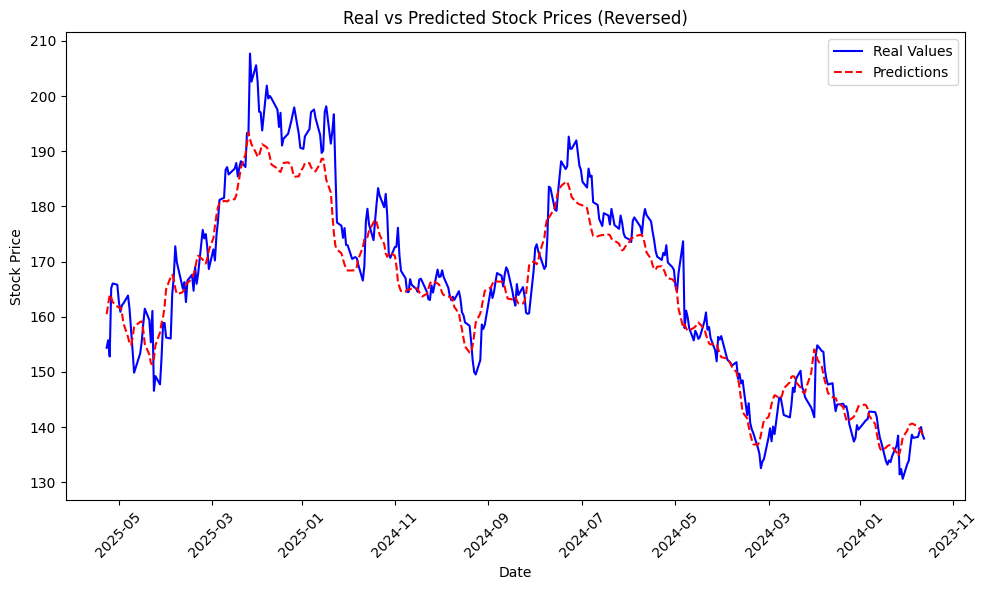

In [59]:
results_rev = evaluate_model_google(model_google_rev, test_loader_rev, dates_rev, train_size_rev)

real_values_rev = results_rev['real_values']
predicted_values_rev = results_rev['predicted_values']
test_dates_rev = results_rev['test_dates']
true_values_denorm_rev = real_values_rev * (price_max_rev - price_min_rev) + price_min_rev
predictions_denorm_rev = predicted_values_rev * (price_max_rev - price_min_rev) + price_min_rev

log_and_plot_predictions(
    true_values=true_values_denorm_rev,
    predictions=predictions_denorm_rev,
    test_dates=test_dates_rev,
    true_values_rolling=None,
    predictions_rolling=None,
    model_name='LSTM',
    attack_name='REV',
    epsilon=0.00,
    res_tab=res_tab,
    similarity_fn=scalar_similarity,
    google=True,
    reverse=True
)

# STEP 5: ATTACK FGSM

In [60]:
from attack.fgsm import fgsm_attack

In [62]:
display(res_tab)

Attack              NA        REV               
ε                 0.00       0.00 0.01 0.10 0.20
Model Metric                                    
LSTM  MAE     4.179501  11.834512  NaN  NaN  NaN
      RMSE    5.340534  14.118211  NaN  NaN  NaN
      SIM     0.999604   0.996613  NaN  NaN  NaN